In [1]:
%load_ext autoreload
%autoreload 2

In [97]:
import real_ips

In [3]:
%pwd

'/Users/andreas/PycharmProjects/aims_lab'

In [4]:
%ls

Section4.ipynb              real_data/
Visualization.ipynb         real_ips.py
__pycache__/                set1/
fingerprinting_skeleton.py  set2/
handout.pdf                 submit.py


In [43]:
import numpy as np

In [637]:
test_locations, test_mac_rsss = real_ips.load_real_data_test('real_data')

In [638]:
train_locations, train_mac_rsss = real_ips.load_real_data_train('real_data')

In [634]:
test_locations, train_locations

(array([[7.22222222, 4.        ],
        [6.44444444, 2.        ],
        [6.44444444, 2.        ]]), array([[1.4 , 1.15],
        [1.2 , 3.1 ],
        [1.35, 5.5 ],
        [1.35, 6.9 ],
        [1.35, 8.8 ],
        [4.1 , 0.8 ],
        [4.7 , 2.8 ],
        [4.8 , 4.  ],
        [4.8 , 5.7 ],
        [4.8 , 8.3 ],
        [7.2 , 1.5 ],
        [7.7 , 3.4 ],
        [7.96, 5.69],
        [7.95, 6.67],
        [7.95, 8.2 ]]))

In [373]:
from sklearn.gaussian_process import GaussianProcessRegressor

In [374]:
from sklearn import preprocessing

In [567]:
mac_encoder = preprocessing.LabelEncoder()

In [850]:
all_macs = set.union(*[set(list(mac_rss[:,0])) for mac_rss in test_mac_rsss])

In [884]:
shared_macs = set.intersection(*[set(list(mac_rss[:,0])) for mac_rss in test_mac_rsss])
shared_macs = set.intersection(shared_macs, *[set(list(mac_rss[:,0])) for mac_rss in train_mac_rsss])

In [885]:
mac_encoder.fit(list(shared_macs))

LabelEncoder()

In [886]:
len(mac_encoder.classes_)

26

In [887]:
def convert_mac_to_labels(rsss, mac_encoder):
    rsss = np.array(rsss, copy=True)
    for i in range(len(rsss)):
        rsss[i] = rsss[i][np.isin(rsss[i][:,0], mac_encoder.classes_), :]
        rsss[i][:,0] = mac_encoder.transform(rsss[i][:, 0])
        rsss[i] = rsss[i].astype(int)
    return rsss

train_rsss=convert_mac_to_labels(train_mac_rsss, mac_encoder)
test_rsss=convert_mac_to_labels(test_mac_rsss, mac_encoder)


In [888]:
[(len(mac_rss), len(label_rss)) for mac_rss, label_rss in zip(train_mac_rsss, train_rsss)]

[(1520, 1053),
 (907, 631),
 (1087, 726),
 (920, 764),
 (771, 729),
 (1093, 818),
 (1128, 796),
 (1245, 985),
 (1004, 823),
 (981, 911),
 (1121, 875),
 (1071, 784),
 (1005, 773),
 (927, 714),
 (859, 722)]

In [889]:
min([np.min(rss) for rss in train_rsss]), min([np.min(rss) for rss in test_rsss])

(-93, -91)

In [890]:
lowest_rss = -94 # is a really shoddy signal, acc to https://www.accuware.com/support/knowledge-base/what-is-the-signal-strength-rss/

In [891]:
#for i, train_rss in enumerate(train_rsss):
sorted([len(train_rss) for train_rss in train_rsss])

[631, 714, 722, 726, 729, 764, 773, 784, 796, 818, 823, 875, 911, 985, 1053]

In [892]:
all_labels = list(range(len(mac_encoder.classes_)))

def data_by_mac(rsss):
    locations_by_mac = [[] for i in all_labels]
    rss_by_mac =  [[] for i in all_labels]
    
    all_labels_set = set(all_labels)

    for i, train_rss in enumerate(train_rsss):
        location = train_locations[i]
        found_macs = set()
        for sample in train_rss:
            locations_by_mac[sample[0]].append(location)
            rss_by_mac[sample[0]].append(sample[1])
            found_macs.add(sample[0])

        for missing_mac in all_labels_set - found_macs:
            locations_by_mac[missing_mac].append(location)
            rss_by_mac[missing_mac].append(lowest_rss)
    return [np.array(location_by_mac) for location_by_mac in locations_by_mac], np.array(rss_by_mac)

locations_by_mac, rss_by_mac = data_by_mac(train_rsss)

In [893]:
from sklearn.gaussian_process.kernels import RBF, WhiteKernel

In [913]:
gps = [GaussianProcessRegressor(kernel=1*RBF(3.0)+WhiteKernel(0.3), n_restarts_optimizer=10, normalize_y=True) 
       for i in range(len(all_labels))]


In [914]:
from tqdm import tqdm_notebook

In [915]:
for i, (locations, rsss) in tqdm_notebook(enumerate(zip(locations_by_mac, rss_by_mac)), total=len(rss_by_mac)):
    gps[i].fit(np.array(locations).astype(float), np.array(rsss).astype(float))

In [916]:
gps[0].predict([(1,1)], return_std=True)

(array([-67.43884019]), array([3.14269869]))

In [917]:
min_grid = np.floor(np.min(train_locations[:], axis=0))
max_grid = np.ceil(np.max(train_locations[:], axis=0))

In [918]:
min_grid, max_grid

(array([1., 0.]), array([8., 9.]))

In [919]:
min_grid=(0,0)
max_grid=(9,9)

In [935]:
tics = 15
grid_locations = np.vstack([[(x, y) 
                  for x in np.linspace(min_grid[0], max_grid[0], tics) 
                           for y in np.linspace(min_grid[1], max_grid[1], tics)], train_locations])


In [936]:
train_loc_scale_by_label_grid = []
for grid_location in tqdm_notebook(grid_locations):
    #print('.', end='')
    loc_scale_by_label = []
    for label in all_labels:
        loc, scale = gps[label].predict([grid_location], return_std=True)
        loc_scale_by_label.append((loc.item(), scale.item()))
    train_loc_scale_by_label_grid.append(loc_scale_by_label)

In [922]:
import fingerprinting_skeleton

In [923]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

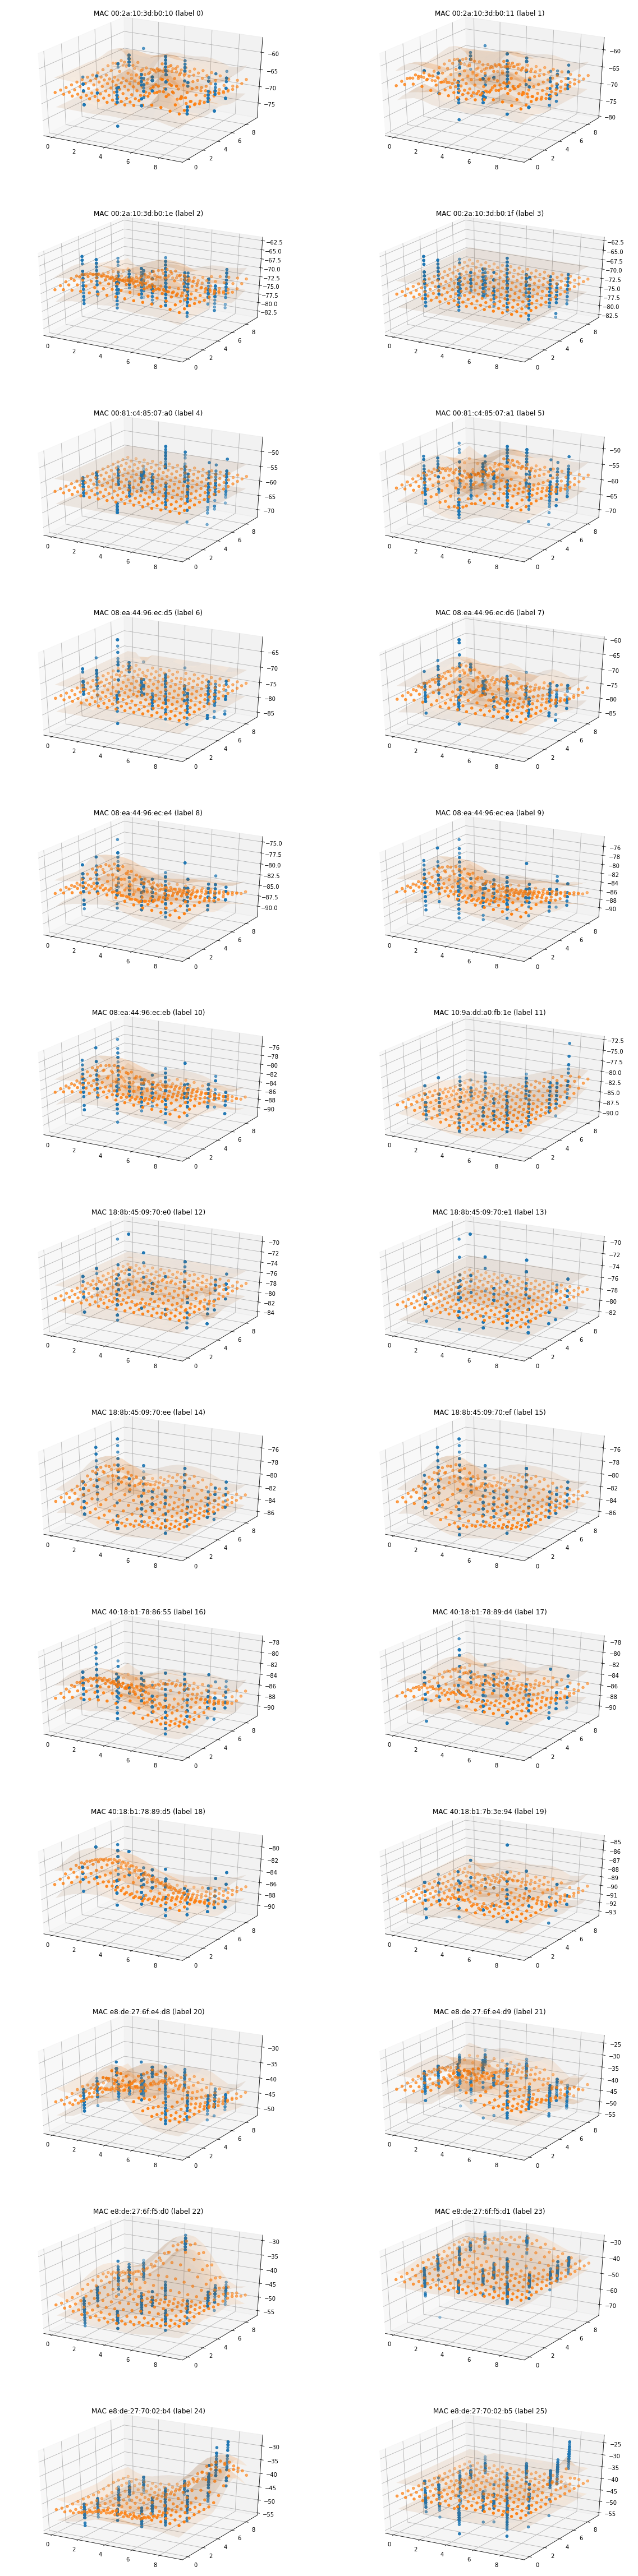

In [963]:
fig = plt.figure(figsize=(20,130))
for label in all_labels:
    ax = fig.add_subplot(20, 2, label+1, projection='3d')
    ax.scatter(locations_by_mac[label][:,0], locations_by_mac[label][:,1], rss_by_mac[label])
    
    wlocations = grid_locations[:-len(train_locations),:]
    xs = wlocations[:,0]
    xs = xs.reshape((tics,tics))
    ys = wlocations[:,1].reshape((tics, tics))
    zs, scale = gps[label].predict(wlocations, return_std=True)
    ax.scatter(xs, ys, zs, color='C1')
    ax.plot_surface(xs, ys, (zs + scale).reshape((tics, tics)), color='C1', alpha=0.1)
    ax.plot_surface(xs, ys, (zs - scale).reshape((tics, tics)), color='C1', alpha=0.1)
    ax.set_title('MAC %s (label %s)' % (mac_encoder.classes_[label], label))
             
                 

In [925]:
test_rsss[0].shape

(820, 2)

In [938]:
from scipy.stats import norm

In [939]:
def fit_data(test_rsss, all_labels):
    """
    :param train_db: RSS points collected at known locations
    :param n_samples: Number of RSS samples per location
    :param n_ap: Number of access points
    :return: Wifi fingerprint database; We approximate the RSS at each location with a Gaussian
    """

    print("-> Modeling RSS with Gaussian dist...", end='')

    test_loc_scale_by_label_location = []
    
    for test_rss in test_rsss:
        rss_by_mac = [[] for i in all_labels]
        
        for label, rss in test_rss:
            rss_by_mac[label].append(rss)
            
        loc_scale_by_label = []
        for label in all_labels:
            samples = rss_by_mac[label]
            if samples:
                loc, scale = norm.fit(np.array(samples))
            else:
                loc, scale = lowest_rss, 0
            loc_scale_by_label.append((loc, scale))
            
        test_loc_scale_by_label_location.append(loc_scale_by_label)
    
    print("done")
    return test_loc_scale_by_label_location

In [940]:
test_loc_scale_by_label_location = fit_data(test_rsss, all_labels)

-> Modeling RSS with Gaussian dist...done


In [941]:
def predict(test_loc_scale_by_label_location, train_loc_scale_by_label_grid, grid_locations):
    locations = []
    for test_loc_scale_by_label in test_loc_scale_by_label_location:
        kale_sums_by_location = []
        for train_loc_scale_by_label in train_loc_scale_by_label_grid:
            kale_sum = 0.
            for (test_loc, test_scale), (train_loc, train_scale) in zip(test_loc_scale_by_label, train_loc_scale_by_label):
                if not test_scale or not train_scale:
                    continue
                kale_sum += fingerprinting_skeleton.norm_kale(train_loc, train_scale, test_loc, test_scale)
            kale_sums_by_location.append(kale_sum)
                    
        best_location_index = np.argmin(kale_sums_by_location)
        #print(kale_sums_by_location)
        print(best_location_index)
        best_location = grid_locations[best_location_index]
        
        locations.append(best_location)
        
    return locations
            

In [942]:
predicted_locations = predict(test_loc_scale_by_label_location, train_loc_scale_by_label_grid, grid_locations)

145
99
170


In [943]:
print(predicted_locations)

[array([5.78571429, 6.42857143]), array([3.85714286, 5.78571429]), array([7.07142857, 3.21428571])]


In [944]:
import csv

In [945]:
with open('real_data/test/location.txt', 'w') as f:
    csv.writer(f).writerows(predicted_locations)